In [1]:
import numpy as np
from scipy.integrate import simpson
import matplotlib.pyplot as plt
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from symbolic_pofk import linear_new, syren_baryon
from symbolic_pofk.pk_to_hmf import full_pipeline_hmf, mass_to_radius, f_sigma_tinker500c, sigma_vals_from_pk

In [2]:
# ---- 1. Set cosmology and mass range ----
cosmo_params = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
cosmology.addCosmology('compareCosmo', **cosmo_params)
cosmo = cosmology.setCosmology('compareCosmo')

### Verifier les resultats de P(k) (Power Spectrum (Mpc/h)**3)

In [3]:
k = np.logspace(-3, 1, 1000)
pk_lin = linear_new.plin_new_emulated(
        k, As=2.105, Om=0.31, Ob=0.02242/(0.672**2), h=0.672, ns=0.95,
        mnu=0.0, w0=-1.0, wa=0.0, a=1
)
# print(f"Pk from symbolic pofk : {pk_lin[:10]}")


### The Baryon effect 

In [4]:
S = syren_baryon.S_hydro(k,
    Omega_m = 0.31,
    sigma_8 = 0.81,
    A_SN1 = 1e-5,
    A_SN2 = 1e-5,
    A_AGN1 = 1e-5,
    A_AGN2 = 1e-5,
    a = 1.0,
    hydro_model = "IllustrisTNG"
)
# # print(S)
# mask = S < 0.95
# k_sup= k[mask]
# s_sup = S[mask]
# print("The values of S(k) < 0.95:")
# for ki, si in zip(k_sup, s_sup):
#     print(f"k = {ki:.4f}  →  S(k) = {si:.3f}")



### Compare the Power Spectrum from pipeline (no baryon effect) vs PS from Colossus

In [5]:
pk_baryon = pk_lin * S 
pk_matter = cosmo.matterPowerSpectrum(k, z=0, model='eisenstein98')
ratio_ps = np.abs(pk_lin - pk_matter) / pk_matter * 100
# mask_ps = ratio_ps > 5
# kps = k[mask_ps]
# rps = ratio_ps[mask_ps]
# for k1, r in zip(kps, rps): 
#     print(f'k = {k1:.3f} -> Ratio_PS = {r:.3f}%')
# print(f"pk_baryon = {pk_baryon[:10]}")
print(f"Ratio between baryon P(k) and linear P(k) from Colossus: {ratio_ps[:10]}, min/max: {np.min(ratio_ps):.3f}%/{np.max(ratio_ps):.3f}% ")


Ratio between baryon P(k) and linear P(k) from Colossus: [0.64668276 0.64881744 0.65095646 0.65310059 0.65525054 0.65740697
 0.65957044 0.66174147 0.66392048 0.66610786], min/max: 0.002%/3.959% 


### Compare Sigma from Colossus and pipeline with 'mass_to_radius uses 500 * cosmo.rho_c(0) * 1E9' (mdef = 500c)


In [6]:
from colossus.halo.mass_so import M_to_R
from symbolic_pofk.pk_to_hmf import mass_to_radius
z= 0.0
M_vals = np.logspace(12,15,50)
#R from Colossus
R_vals = M_to_R(M_vals, z=0.0, mdef='500c') *1e-3

#R from the Pipeline
R_valsPL = mass_to_radius(M_vals, cosmo.rho_c(z) ) * 1e-3
R_valsPL_500m = mass_to_radius(M_vals, cosmo.rho_m(z) ) * 1e-3
print(f"R_vals colossus: {R_vals[:10]}")
print(f"R_vals Pipeline: {R_valsPL[:10]}")

my_sig = sigma_vals_from_pk(k, pk_lin, M_vals, cosmo.rho_c(0) * 1E9)
my_sig_500m = sigma_vals_from_pk(k, pk_lin, M_vals, cosmo.rho_m(0) * 1E9)
sig_col = cosmo.sigma(R_vals, z,kmin=1e-3, kmax=10 )

ratio = np.abs((my_sig - sig_col ) / sig_col) * 100

print(f"Sigma 500c from pipeline : {my_sig[:10]}, Min-Max : {np.min(my_sig)}, {np.max(my_sig)}, {len(my_sig)}")
# print(f"Sigma 500m from pipeline : {my_sig_500m[:10]}, Min-Max : {np.min(my_sig_500m)}, {np.max(my_sig_500m)}, {len(my_sig_500m)}")

print(f"Sigma from Colossus : {sig_col[:10]}, Min-Max : {np.min(sig_col)}, {np.max(sig_col)}, {len(sig_col)}")
print(f"Ratio between pipeline and Colossus is  : {ratio[:10]}, Min-Max : {np.min(ratio):.4f}%, {np.max(ratio):.4f}%, {len(ratio)}")




R_vals colossus: [0.11982305 0.12558811 0.13163055 0.13796371 0.14460157 0.15155881
 0.15885078 0.16649358 0.17450411 0.18290005]
R_vals Pipeline: [0.11982305 0.12558811 0.13163055 0.13796371 0.14460157 0.15155881
 0.15885078 0.16649358 0.17450411 0.18290005]
Sigma 500c from pipeline : [4.15465724 4.14192911 4.12809372 4.11307045 4.09677606 4.07912527
 4.06003168 4.03940879 4.0171713  3.99323675], Min-Max : 2.225309961099135, 4.154657235705475, 50
Sigma from Colossus : [4.16966492 4.15673274 4.14265787 4.1273693  4.11079828 4.09287855
 4.0735445  4.05270768 4.03026573 4.00612057], Min-Max : 2.220292637969842, 4.169664915966047, 50
Ratio between pipeline and Colossus is  : [0.35992533 0.35613617 0.35156527 0.34643966 0.34110721 0.33602954
 0.33172127 0.32814823 0.3249025  0.32160353], Min-Max : 0.0010%, 0.3599%, 50


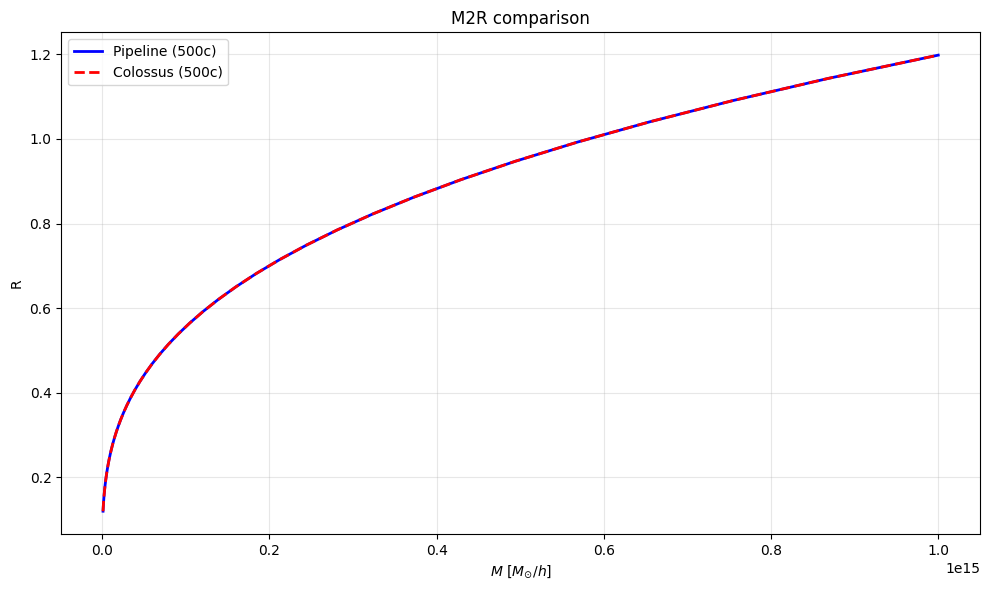

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(M_vals, R_valsPL, 'b-', linewidth=2, label='Pipeline (500c)')
plt.plot(M_vals, R_vals, 'r--', linewidth=2, label='Colossus (500c)')
plt.xlabel(r'$M \ [M_{\odot}/h]$')
plt.ylabel('R')
plt.title('M2R comparison')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

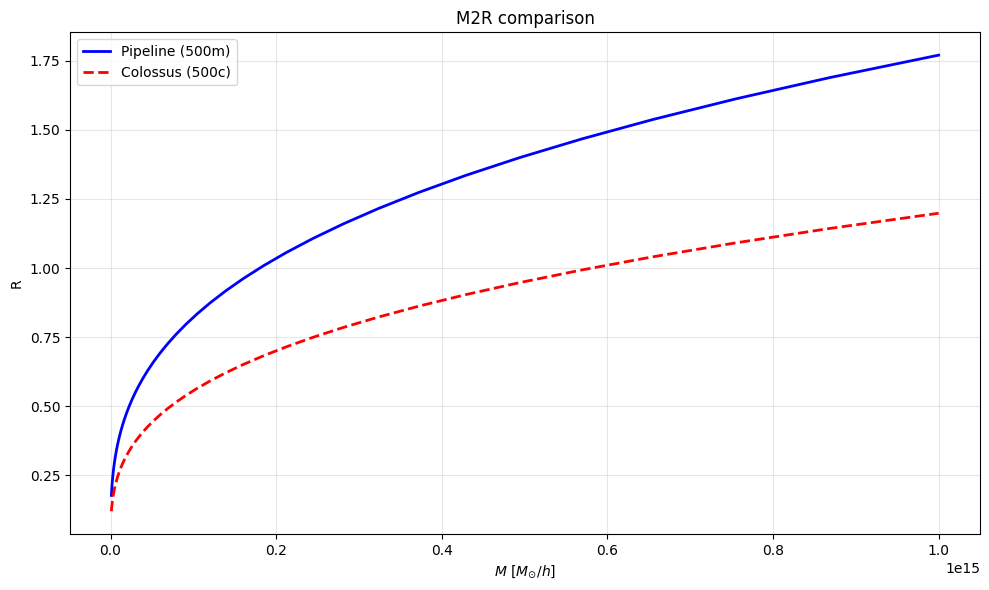

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(M_vals, R_valsPL_500m, 'b-', linewidth=2, label='Pipeline (500m)')
plt.plot(M_vals, R_vals, 'r--', linewidth=2, label='Colossus (500c)')
plt.xlabel(r'$M \ [M_{\odot}/h]$')
plt.ylabel('R')
plt.title('M2R comparison')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

### Compare f_sigma from Pipeline and Colossus

In [16]:
from symbolic_pofk.pk_to_hmf import f_sigma_tinker500c
ps_args = dict(model='camb', kmax=1e2, ps_type='tot')
# F_sigma_500c from Pipeline
f_sigma500c = f_sigma_tinker500c(sig_col, 0,0.31,0.1-0.31)
# f_sigma500m = f_sigma_tinker500c(my_sig_500m, 0, 0.31, 0.69)


# F_sigma_500c from Colossus
f_sigmaCol = mass_function.massFunction(M_vals, z, q_in="M", q_out="f",
    model='tinker08', mdef="500c", ps_args=ps_args)
ratio_fsigma = np.abs((f_sigma500c - f_sigmaCol) / (f_sigmaCol) * 100)
# ratio_fsigma_500m = np.abs((f_sigma500m - f_sigmaCol) / (f_sigmaCol) * 100)

# print(f"F_Sigma_500c from pipeline : {f_sigma500c[:10]}, Min-Max : {np.min(f_sigma500c)}, {np.max(f_sigma500c)}, {len(f_sigma500c)}")
# print(f"F_Sigma_500c from Colossus : {f_sigmaCol[:10]}, Min-Max : {np.min(f_sigmaCol)}, {np.max(f_sigmaCol)}, {len(f_sigmaCol)}")
print(f"Ratio f_sigma500c between pipeline and Colossus: {ratio_fsigma[:10]}, Min-Max : {np.min(ratio_fsigma):.3f}%, {np.max(ratio_fsigma):.3f}%")
# print(f"Ratio f_sigma500m between pipeline and Colossus: {ratio_fsigma_500m[:10]}, Min-Max : {np.min(ratio_fsigma_500m):.3f}%, {np.max(ratio_fsigma_500m):.3f}%")



Ratio f_sigma500c between pipeline and Colossus: [ 8.75266324  9.34672799  9.99609762 10.70681145 11.48560829 12.34002809
 13.27855133 14.31099065 15.4485847  16.70401584], Min-Max : 8.753%, 11511.632%


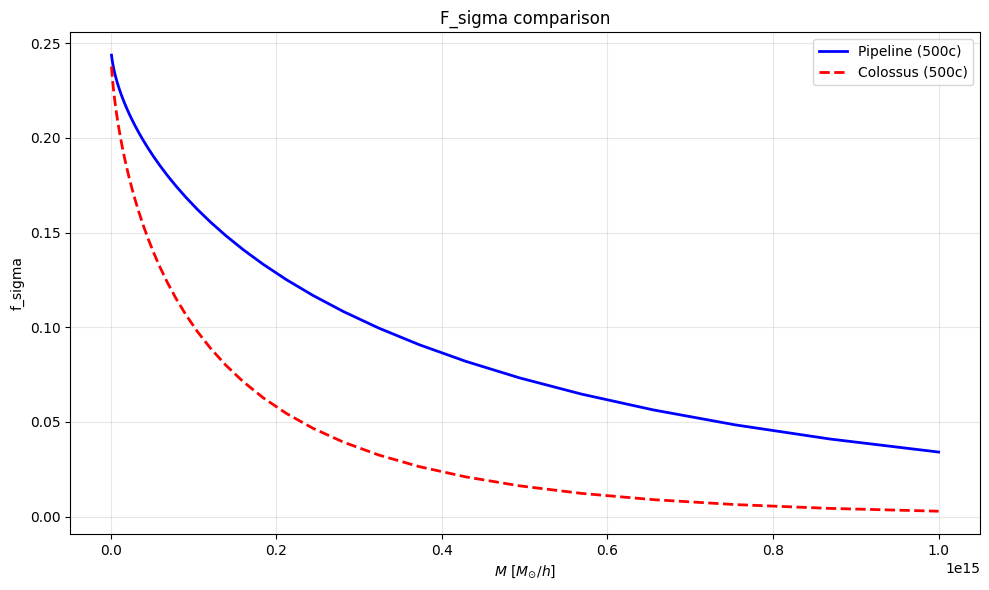

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(M_vals, f_sigma500c, 'b-', linewidth=2, label='Pipeline (500c)')
plt.plot(M_vals, f_sigmaCol, 'r--', linewidth=2, label='Colossus (500c)')
plt.xlabel(r'$M \ [M_{\odot}/h]$')
plt.ylabel('f_sigma')
plt.title('F_sigma comparison')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

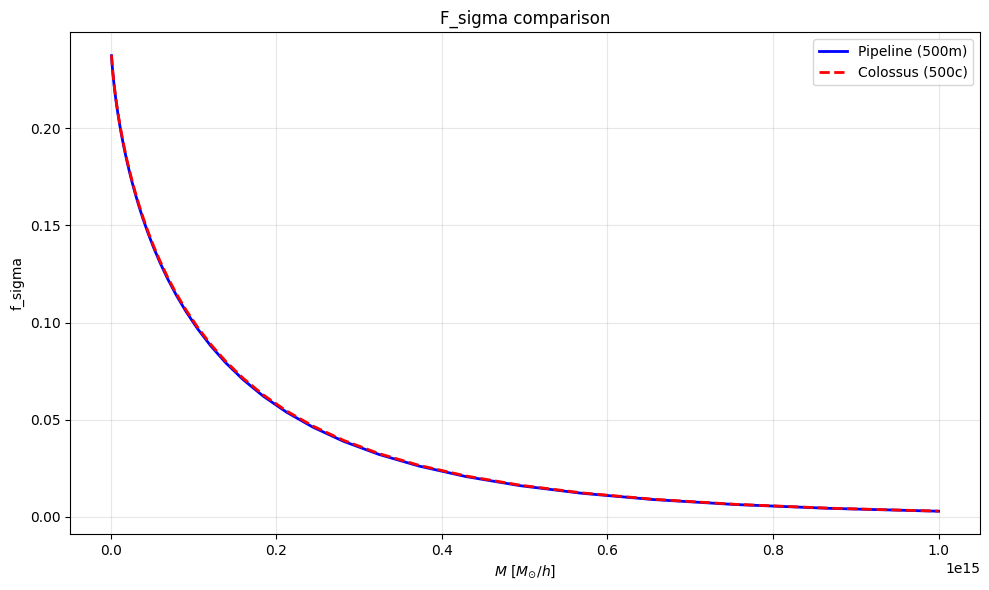

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(M_vals, f_sigma500m, 'b-', linewidth=2, label='Pipeline (500m)')
plt.plot(M_vals, f_sigmaCol, 'r--', linewidth=2, label='Colossus (500c)')
plt.xlabel(r'$M \ [M_{\odot}/h]$')
plt.ylabel('f_sigma')
plt.title('F_sigma comparison')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

==> Big difference between "f_sigma_500c" from Pipeline and Colossus, I think this is the main issue that makes hmf from Pipeline have big difference with Colossus. 

When i compare f_sigma from pipeline with mdef=500m then f_sigma_500m = f_sigma_500c Colossus


### Compare HMF between Colossus vs Pipeline (i set mdef= 500m)

In [13]:
ps_args = dict(model='camb',kmin=1e-3, kmax=5E3, ps_type='tot')
hmf_colossus = mass_function.massFunction(M_vals, z, q_in="M", q_out="dndlnM",
    model='tinker08', mdef="500c", ps_args=ps_args)

h = 0.672
hmf_pipeline, sigma_valssss, sig8_valsss = full_pipeline_hmf(As = 2.105,  # 10^9 A_s
                                    h = 0.672,
                                    Om = 0.31,
                                    Ob = 0.02242 / h ** 2,
                                    ns = 0.95,
                                    A_SN1 = 1e-5,
                                    A_SN2 = 1e-5,
                                    A_AGN1 = 1e-5,  
                                    A_AGN2 = 1e-5,
                                    z= z,
                                    M_vals = M_vals,
                                    model = 'Tinker08',
                                    hydro_model = 'IllustrisTNG', 
                                    baryon_effect=False)

ratio_hmf = np.abs(hmf_pipeline - hmf_colossus) / (hmf_colossus) * 100
print(f"Max is {np.max(ratio_hmf):.3f}%,Min is  {np.min(ratio_hmf):.3f}%")


Max is 2.214%,Min is  0.027%


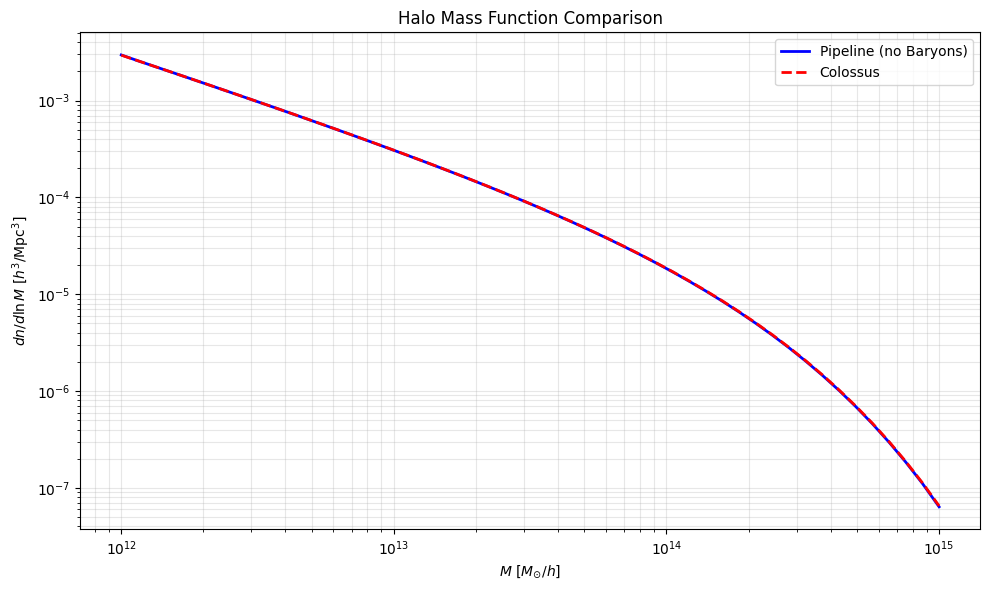

In [14]:
plt.figure(figsize=(10,6))
plt.loglog(M_vals, hmf_pipeline, 'b-', linewidth=2, label='Pipeline (no Baryons)')
plt.loglog(M_vals, hmf_colossus, 'r--', linewidth=2, label="Colossus")
plt.xlabel(r'$M \ [M_{\odot}/h]$')
plt.ylabel(r'$dn/d\ln M \ [h^3/{\rm Mpc}^3]$')
plt.title("Halo Mass Function Comparison")
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

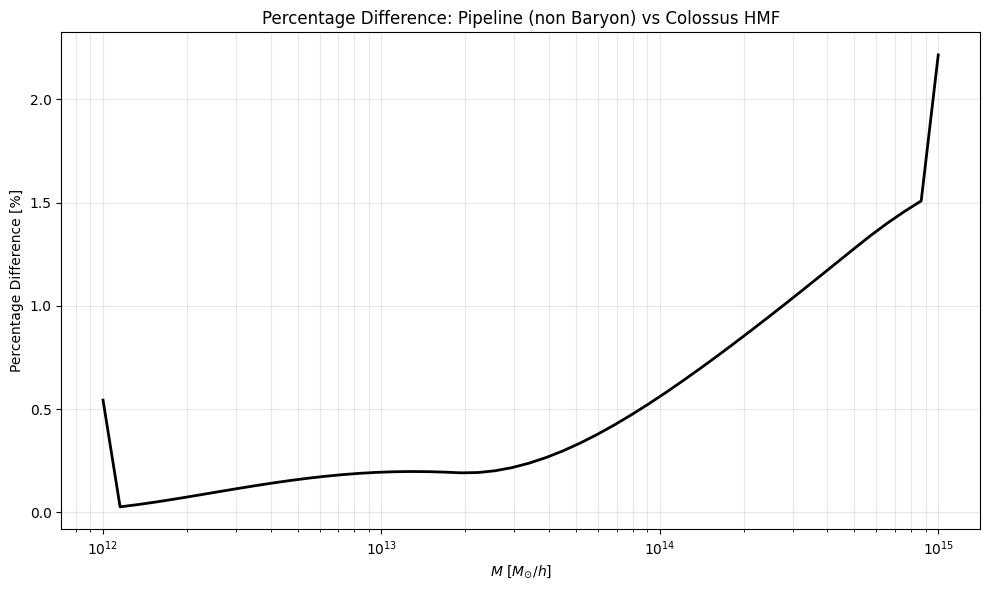

In [15]:
plt.figure(figsize=(10, 6))
plt.semilogx(M_vals, ratio_hmf, 'k-', linewidth=2)
plt.xlabel(r'$M \ [M_{\odot}/h]$')
plt.ylabel('Percentage Difference [%]')
plt.title('Percentage Difference: Pipeline (non Baryon) vs Colossus HMF')
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
from colossus.halo.mass_defs import changeMassDefinition as cmd

k2 = k**2
kR = np.outer(k, [1,2,3,4,5])
print(kR[1])


[0.00100926 0.00201852 0.00302779 0.00403705 0.00504631]


In [ ]:
from colossus.cosmology import cosmology
from colossus.halo import concentration
c = np.array([concentration.concentration(m, 'vir', 0.0, model = 'bullock01') for m in M_vals ])
print((c))

[9.77337955 9.64280839 9.51314903 9.38441163 9.25660406 9.12973371
 9.0038061  8.87882364 8.75478616 8.63170687 8.50961827 8.38855313
 8.26854304 8.14961909 8.031812   7.91515099 7.79966365 7.68537592
 7.57231269 7.46049758 7.3499523  7.24069668 7.13275009 7.02614675
 6.9209313  6.81714817 6.7148414  6.61405487 6.51483029 6.41720503
 6.32121737 6.22690762 6.13431867 6.04349606 5.95448388 5.8673286
 5.78208328 5.69880902 5.61757652 5.53846842 5.46158109 5.38702428
 5.31487239 5.24516272 5.17797028 5.11341663 5.05167405 4.99296148
 4.93736644 4.88490902]
